# Pthread convolution filter

In this notebook I will visualize the result of the Gaussian convolution filter implemented in C using pthreads, and compare with the solution in Python.

## Visualization

Here I just plot and save the result.

In [1]:
import numpy as np #Arrays
import pandas as pd #Read files
import matplotlib.pyplot as plt #Plots

In [2]:
data = pd.read_csv("Data.txt", header=None)[0].to_numpy()
time = pd.read_csv("Time.txt", header=None)[0].to_numpy()
smoothed = pd.read_csv("Smoothed.txt", header=None)[0].to_numpy()

n = smoothed.shape[0]

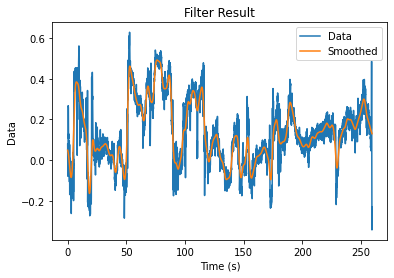

In [3]:
fig = plt.figure()

plt.plot(time[:n], data[:n], label="Data")
plt.plot(time[:n], smoothed, label="Smoothed")

plt.title("Filter Result")
plt.ylabel("Data")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

fig.savefig("Result.png", facecolor="white", transparent=False)

![Result](Result.png)

## Python Comparison

Here I implement the filter in Python, and measure the runtime in Python and using Numba, which compiles the script and runs in parallel

In [4]:
import numba #Python JIT compiler

def smooth():
    '''
        Smooth the data using an gaussian convolution filter

        Returns
            smoothed (np.array): smoothed data
    '''
    smoothed = np.zeros_like(time[:n], dtype=np.float64)
    sigma = 1

    for i in numba.prange(n): #prange = parallel range
        frame_time = time[i]

        kernel = np.exp(-np.power(frame_time - time[:n], 2.0)/2.0*np.power(sigma,2.0))
        kernel = kernel/np.sum(kernel)

        smoothed[i] = np.sum(data[:n]*kernel)

    return smoothed

smooth2 = numba.njit(smooth, parallel=True) # JIT compiler without Python code

smoothed2 = smooth2() #Runs once to avoid measure compilation time

%timeit smooth()
%timeit smooth2()

5.59 s ± 1.54 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
706 ms ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Surprisingly, C code cannot be faster than Python code using Numpy, much less code using a JIT compiler. Probably the time in C can be improved by optimizing the code.

Mode | Time 
-|-
Python | 3.9 s
Python njit parallel | 596 ms
C pthread | 7.18 s
C pthread O3 optimization| 1.40 s

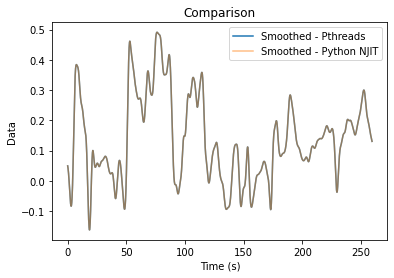

In [8]:
plt.plot(time[:n], smoothed, label="Smoothed - Pthreads")
plt.plot(time[:n], smoothed, label="Smoothed - Python NJIT", alpha=0.5)

plt.title("Comparison")
plt.ylabel("Data")
plt.xlabel("Time (s)")
plt.legend()
plt.show()